In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import *
from torchsmodel import sparsecoding
from utils import plotmontage 
import torch
import time

### Define constants and load data

In [2]:
patch_size = 16
batch_size = 100
patch_overlap = 4 
device = torch.device('cuda')

## Use GPU
gpudataset = naturalscenes(img_dir='data/IMAGES.mat',patch_size=patch_size,patch_overlap=patch_overlap,data_key='IMAGES',device=device)

## Can also use CPU
# cpudataset = naturalscenes(img_dir='data/IMAGES.mat',patch_size=patch_size,patch_overlap=patch_overlap,data_key='IMAGES')

### Visualize patches

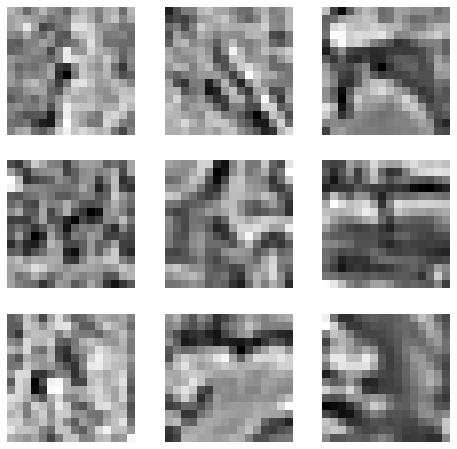

In [3]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(gpudataset), size=(1,)).item()
    img = torchtonp(gpudataset[sample_idx])
    figure.add_subplot(rows, cols, i)
    plt.axis("off")
    plt.imshow(img.squeeze().reshape([patch_size,patch_size]), cmap="gray")
plt.show()

<IPython.core.display.Javascript object>


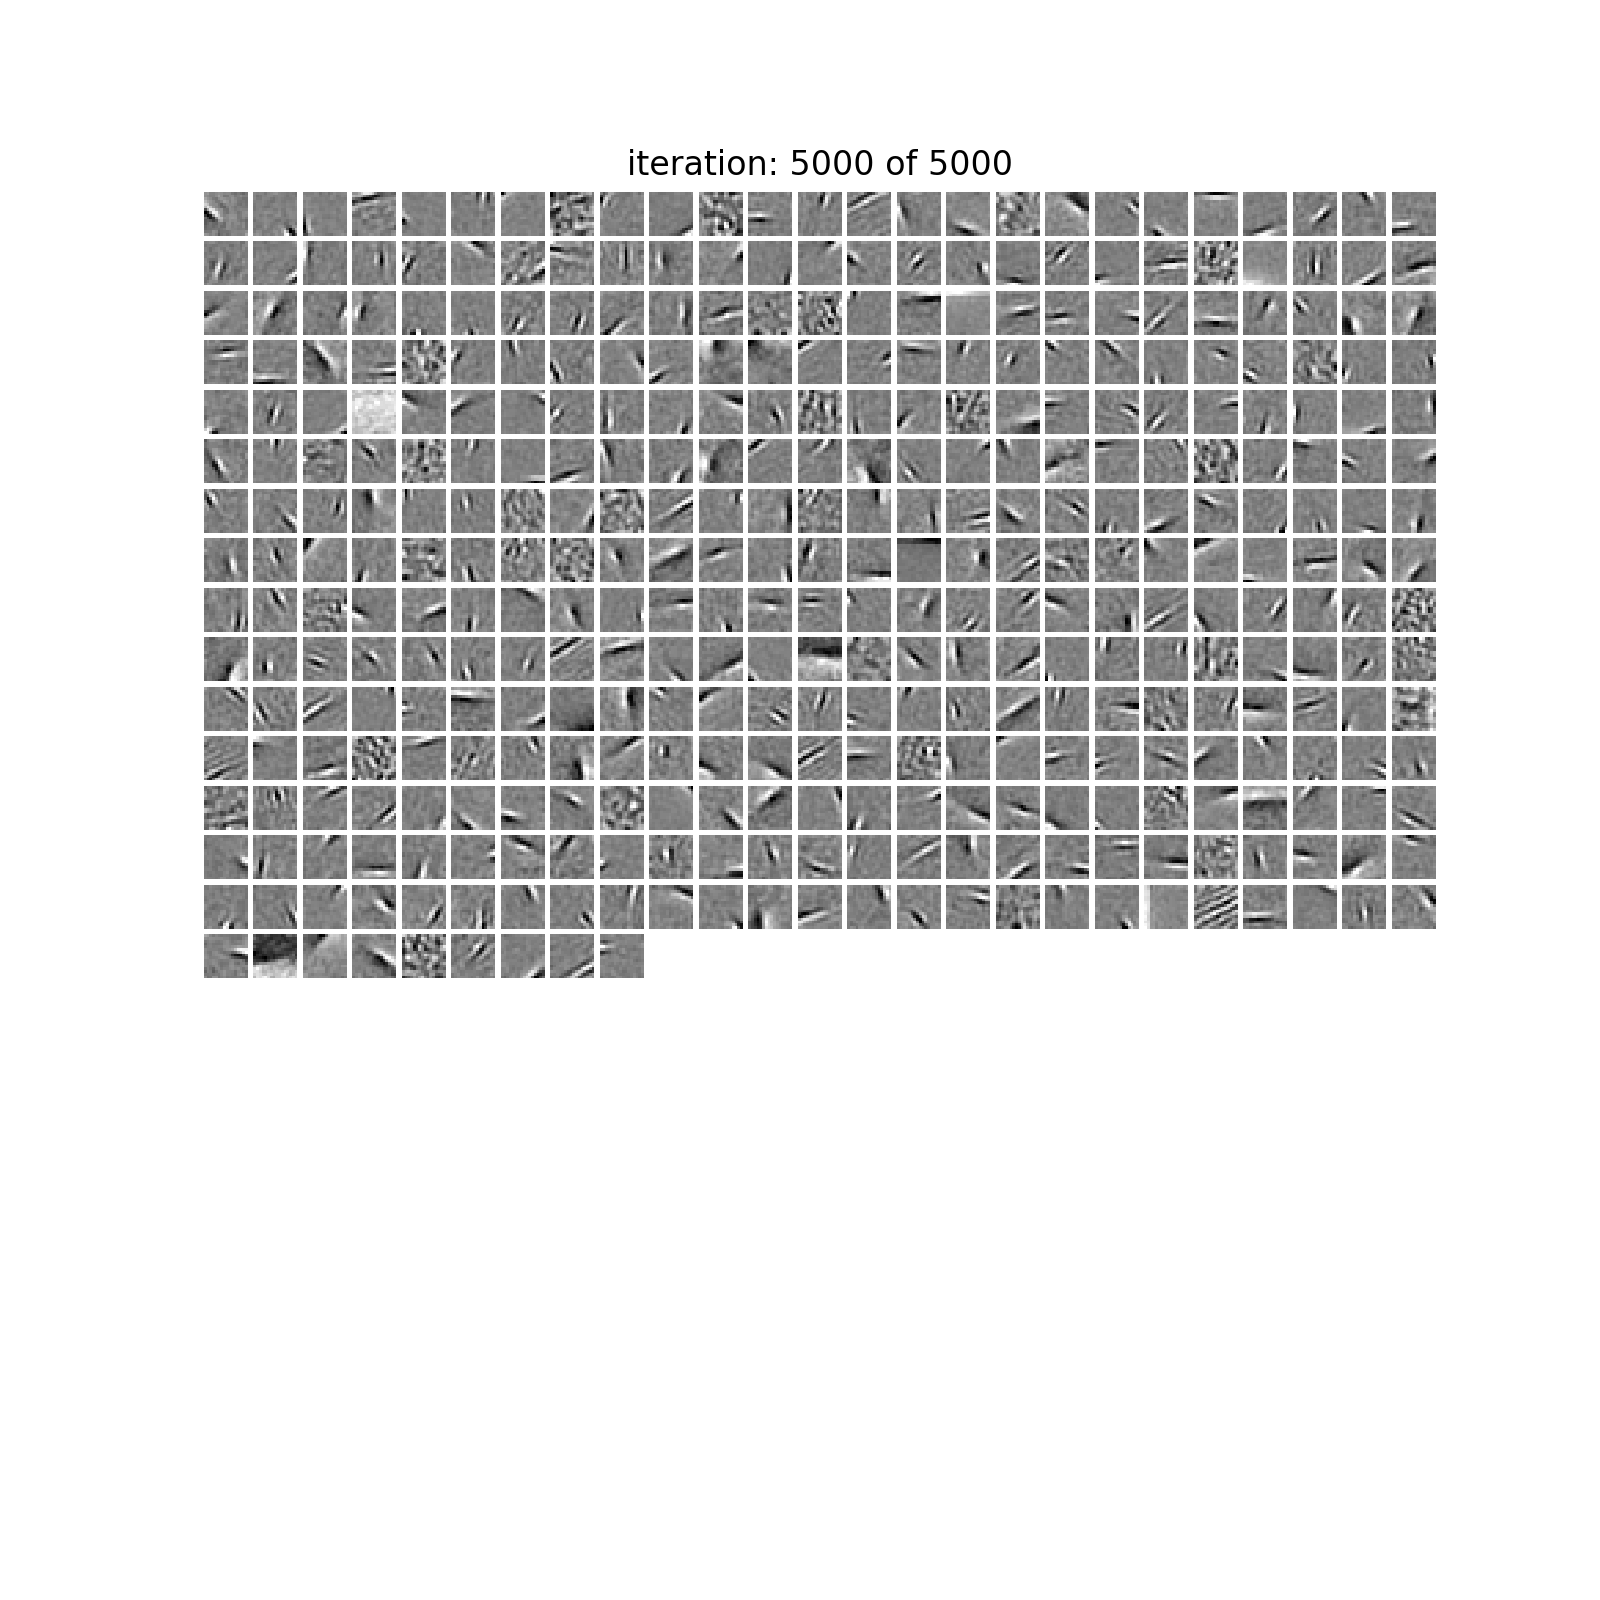

total time: 310.913044


In [14]:
%matplotlib notebook

## MODEL PARAMETERS
n_basis    = 384   # 1.5 times overcomplete
A_n_itr    = 300   # iterations to infer coefficents
lmbda      = 1.    # sparsity parameter
eta        = 5e-2  # step size of LCA dynamics
stop_early = False # stop LCA early
eps        = 1e-2  # not used when stop_early==True
thresh     = 2e-1  # treshold for lca
nabla      = 3e-2  # dictionary gradient step size

montage_update_rate = 50
n_epoch             = 5000

model = sparsecoding(n_basis=n_basis,
                     n=patch_size**2,
                     lmbda=lmbda,
                     eta=eta,
                     eps=eps,
                     stop_early=stop_early,
                     thresh=thresh,
                     nabla=nabla,
                     n_itr=A_n_itr,
                     device=device
                    )

fig,ax = plotmontage(model)
t0 = time.time()
for i in range(n_epoch//montage_update_rate):
    # learn dictionary
    model.learndict(gpudataset,n_epoch=montage_update_rate,batch_size=batch_size)
    # update montage
    fig,ax = plotmontage(model,fig=fig,ax=ax,title='iteration: %d of %d'%(i*montage_update_rate,n_epoch))
t1 = time.time()
fig,ax = plotmontage(model,fig=fig,ax=ax,title='iteration: %d of %d'%(n_epoch,n_epoch))
print('total time: %f'%(t1-t0))


<IPython.core.display.Javascript object>


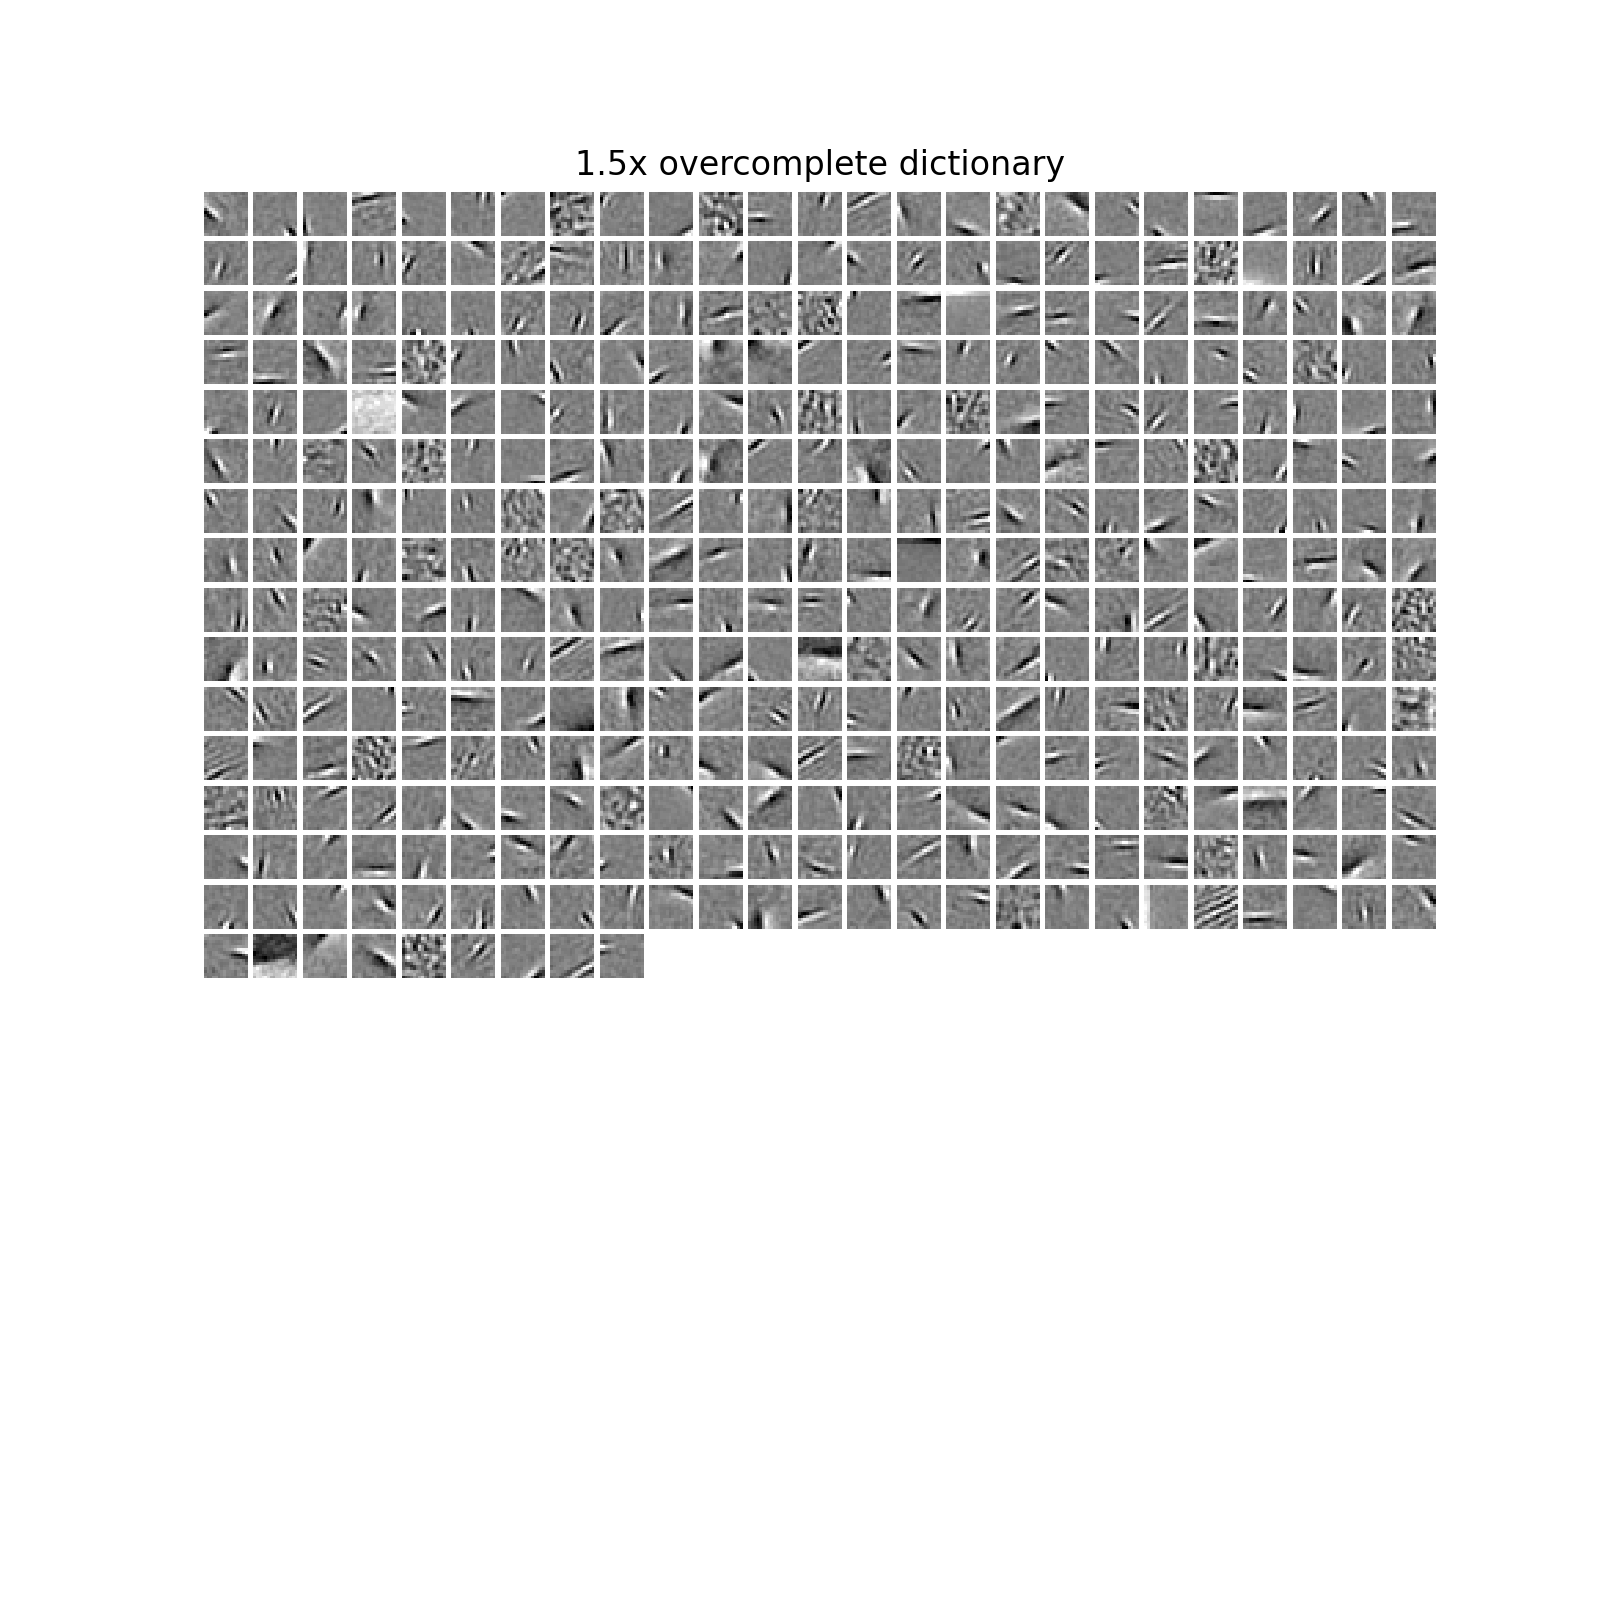

In [15]:
## DISPLAY FINAL DICTIONARY
plotmontage(model,title='1.5x overcomplete dictionary')

## SAVE DICTIONARY TO PKL DUMP
fname = "dictionaries/DICTIONARY_1.5x_overcomplete.p"
model.savedict(fname)